In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torch'

In [ ]:
df = pd.DataFrame([["i love you", "ich liebe dich"],
                    ["i love myself", "ich liebe mich"],
                    ["i like you", "ich mag dich"],
                    ["he love you", "er liebt dich"]], columns=['src', 'tar'])

In [ ]:
df

,src,tar
0,i love you,ich liebe dich
1,i love myself,ich liebe mich
2,i like you,ich mag dich
3,he love you,er liebt dich


In [ ]:
SOS_token = 0
EOS_token = 1

class Tokenizer:
  def __init__(self):
    self.vocab2index = {'<SOS>': SOS_token, '<EOS>': EOS_token}
    self.index2vocab = {SOS_token: '<SOS>', EOS_token: '<EOS>'}
    self.n_vocab = len(self.vocab2index)

  # 새로운 문장 추가
  def add_vocab(self, sentence):
    for word in sentence.split(" "):
      if word not in self.vocab2index:
        self.vocab2index[word] =  self.n_vocab
        self.index2vocab[self.n_vocab] = word
        self.n_vocab += 1

  # 입력 시퀀스 토큰화
  def to_seq(self, sentence):
    l = []
    for word in sentence.split(" "):
      l.append(self.vocab2index[word])
    return l

In [ ]:
src_tokenizer = Tokenizer()
src = df['src']
for src_seq in src:
  src_tokenizer.add_vocab(src_seq)

tar_tokenizer = Tokenizer()
tar = df['tar']
for tar_seq in tar:
  tar_tokenizer.add_vocab(tar_seq)

print(src_tokenizer.vocab2index)
print(tar_tokenizer.vocab2index)

{'<SOS>': 0, '<EOS>': 1, 'i': 2, 'love': 3, 'you': 4, 'myself': 5, 'like': 6, 'he': 7}
{'<SOS>': 0, '<EOS>': 1, 'ich': 2, 'liebe': 3, 'dich': 4, 'mich': 5, 'mag': 6, 'er': 7, 'liebt': 8}


In [ ]:
src_data = [src_tokenizer.to_seq(s) for s in df['src']]  # 입력 시퀀스 토큰화
tar_data = [[SOS_token] + tar_tokenizer.to_seq(s) + [EOS_token] for s in df['tar']]  # 출력 시퀀스 토큰화 + <SOS>, <EOS> 추가
print(src_data)
print(tar_data)

[[2, 3, 4], [2, 3, 5], [2, 6, 4], [7, 3, 4]]
[[0, 2, 3, 4, 1], [0, 2, 3, 5, 1], [0, 2, 6, 4, 1], [0, 7, 8, 4, 1]]


# nn.Embedding()  
---

임베딩 벡터들을 저장한 룩업 테이블  
  

**파라미터**  

num_embeddings(int): 사전 크기  

embedding_dim(int): 각 임베딩 벡터 크기  

---------옵셔널----------  


padding_idx(int): 임베딩 벡터에서 padding_idx에 해당하는 인덱스는 기울기에 영향을 주지 않게 된다. 값은 모두 0으로 초기화된다.  
max_norm(float): 각 임베딩 벡터의 norm이 max_norm 보다 커지는 것을 방지 (클램프)  
이외에 norm_type, scale_grad_by_freq, sparse가 있다.

## nn.LSTM  
input_size는 임베딩 차원과 같다.  
rnn = nn.LSTM(input_size, hidden_size)
  

---



### output, (h, c) = rnn(x, (h, c))  
x: 입력 텐서  
h, c: 초기 히든 스테이트, 셀 상태 텐서
  

output: 모든 시점에서의 히든 스테이트들을 담은 텐서  
h, c: 마지막 히든 스테이트, 셀 상태  

---


### 입력 x shape  
unbatched: (시퀀스 길이, input_size)   
batch_first=False: (시퀀스 길이, 배치 크기, input_size)  
batch_first=True: (배치 크기, 시퀀스 길이, input_size)  
파이토치의 LSTM이 기대하는 입력은 (seq_len, batch_size, input_size) 3차원이다.   (false기준)  
따라서 unbatched 입력이라도 3차원으로 바꾸는 과정이 필요하다.  
-> x.view(seq_len, batch_size, -1)
  

---


### h, c shape  
(num_directions * num_layers, 배치크기, hidden_size)  
이때 num_directions은 단방향일때 1, 양방향일때 2


---


### batch_first 파라미터
pytorch의 RNN 계열 모듈 - nn.RNN, nn.LSTM, nn.GRU - 에서 입력 텐서의 차원 순서를 결정하는 옵션. False가 디폴트이다.  

batch_first=True: (배치크기, 시퀀스길이, input_size) - 배치 차원을 가장 앞에 두는 구조. 실무에서는 거의 항상 True를 쓴다.  
batch_first=False (default): (시퀀스길이, 배치크기, input_size)  
  
True, False에 따라 출력(output)의 shape도 동일한 순서로 바뀐다.  
단, (h, c)의 shape은 동일하다.


In [ ]:
embed_size = 4
hidden_size = 6

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()  # nn.Module의 init 실행
    self.embed = nn.Embedding(src_tokenizer.n_vocab, embed_size)
    self.rnn = nn.LSTM(embed_size, hidden_size)

  def forward(self, x, h, c):
    x = self.embed(x)
    x = x.view((1, 1, -1))
    output, (h, c) = self.rnn(x, h, c)
    return h, c

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(tar_tokenizer.n_vocab, embed_size)
        self.rnn = nn.LSTM(embed_size, hidden_size)

    def forward(self, x, h, c):
        x = self.embed(x)
        x = x.view((1, 1, -1))
        output, (h, c) = self.rnn(x, h, c)
        return h, c

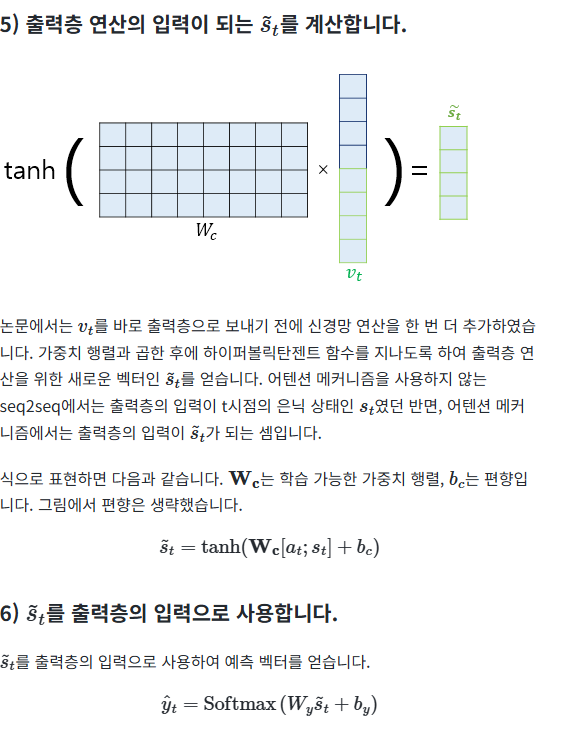

In [ ]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        # context vector와 은닉상태를 concat 다시 hidden_size로
        self.wc = nn.Linear(hidden_size * 2, hidden_size)
        self.tanh = nn.Tanh()
        self.wy = nn.Linear(hidden_size, tar_tokenizer.n_vocab)
    
    def forward(self, x):
        x = self.wc(x)  # (1, 1, hidden_size*2) -> (1, 1, hidden_size)
        x = self.tanh(x)
        x = self.wy(x)  # (1, 1, hidden_size) -> (1, 1, n_vocab)
        x = F.log_softmax(x, dim=2)
        return x

In [ ]:
encoder = Encoder()
decoder = Decoder()
attention = Attention()

# 옵티마이저
enc_optimizer = optim.RMSprop(encoder.parameters(), lr=0.01)
dec_optimizer = optim.RMSprop(decoder.parameters(), lr=0.01)
att_optimizer = optim.RMSprop(attention.parameters(), lr=0.01)

criterion = nn.NLLLoss()  # Negative Log Likelihood Loss
loss_history = []
for epoch in range(500):
    loss_avg = []
    
    for batch in range(len(src_data)):
        loss = 0
        src_train = torch.LongTensor(src_data[batch]) # 입력 시퀀스
        tar_train = torch.LongTensor(tar_data[batch]) # 정답 시퀀스

        # 은닉상태 초기화
        h = torch.zeros((1, 1, hidden_size))
        c = torch.zeros((1, 1, hidden_size))

        enc_out = torch.Tensor([])  # 인코더의 모든 타임스텝의 은닉상태를 저장
        for i in range(len(src_train)):
            h, c = encoder(src_train[i], h, c)
            enc_out = torch.cat((enc_out, h))  # (src_len, 1, hidden_size) -  모든 타임스텝의 은닉상태 저장
        
        rate = 0.5  # teacher forcing 비율
        if rate > np.random.rand():
            # 디코더 입력으로 정답 시퀀스 사용
            for i in range(len(tar_train)-1):
                h, c = decoder(tar_train[i], h, c)
                score = enc_out.matmul(h.view((1, hidden_size, 1)))  # (src_len, 1, hidden_size) * (1, hidden_size, 1) -> (src_len, 1, 1)
                attn_dist = F.softmax(score, dim=0)
                attn_value = torch.sum(enc_out * attn_dist, dim=0).view((1, 1, -1))  # (1, 1, hidden_size
                con = torch.cat((attn_value, h), dim=2)  # (1, 1, hidden_size*2)
                output = attention(con)  # (1, 1, n_vocab)
                loss += criterion(output.view((1, -1)), tar_train[i+1].view(-1))

        else:
            # 디코더 입력으로 이전 출력 사용
            decoder_input = tar_train[0]  # <SOS>
            for i in range(len(tar_train)-1):
                h, c = decoder(decoder_input, h, c)
                score = enc_out.matmul(h.view((1, hidden_size, 1)))  # (src_len, 1, hidden_size) * (1, hidden_size, 1) -> (src_len, 1, 1)
                attn_dist = F.softmax(score, dim=0)
                attn_value = torch.sum(enc_out * attn_dist, dim=0).view((1, 1, -1))  # (1, 1, hidden_size
                con = torch.cat((attn_value, h), dim=2)  # (1, 1, hidden_size*2)
                output = attention(con)  # (1, 1, n_vocab)
                topv, topi = output.topk(1)  # 가장 높은 확률의 단어 선택
                decoder_input = topi[0].detach()  # 다음 디코더 입력
                loss += criterion(output.view((1, -1)), tar_train[i+1].view(-1))
                if decoder_input == EOS_token:
                    break

        if (epoch + 1) % 50 == 0:
            print(epoch + 1, batch, loss.item())
            print(' '.join([tar_tokenizer.index2vocab[t] for t in tar_train.detach().numpy()[1: ]]))
        
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()
        att_optimizer.zero_grad()

        loss = loss / len(df)
        loss.backward()

        enc_optimizer.step()
        dec_optimizer.step()
        att_optimizer.step()

        loss_avg.append(loss.item())

    loss_history.append(sum(loss_avg))

    if (epoch + 1) % 50 == 0:
        print('avg loss', loss_history[-1])
        print('=============================')
